#  Model analysis for improvement

In [1]:
#Libraries required:

In [2]:
import glob
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import pandas as pd
import h5py
import pickle
import time
import altair as alt
import math
import csv
import datetime

import scipy
from scipy import stats

import skimage.io
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter 
from skimage.transform import resize


from matplotlib import pyplot as plt
from matplotlib import cm as CM

#To create Sequential model:
from keras import models

#To add layers to the model:
from keras import layers

from shutil import copyfile
import statsmodels.api as sm


C:\Users\JORGE\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\JORGE\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The main goal of this notebook is to find the way to **improve the outcomes** of the selected model.<br>
We will analize the **prediction error** of the model for this purpose.

We will focus our analysis on high values of prediction error in order to identify their patterns.
Steps:
- Data collection
- Variables Selection:
    - Ground_truth vs error
    - Density vs error (dispersion, overlapping) 
    - Brightness vs error
- Clustering of High Prediction Error
- Conclusions
- TODO

## Data Collection:

Let´s set the list of paths to the test dataset of TRANCOS

In [3]:
root = './'
# Path to images folder 
test_path = root+'TRANCOS_v3/images'

In [4]:
#List of images paths:

img_paths = []

for img_path in glob.glob(os.path.join(test_path,'image-3*.jpg')):
        img_paths.append(img_path.replace('\\','/'))

len(img_paths)

421

In [5]:
img_paths[:5]

['./TRANCOS_v3/images/image-3-000001.jpg',
 './TRANCOS_v3/images/image-3-000002.jpg',
 './TRANCOS_v3/images/image-3-000003.jpg',
 './TRANCOS_v3/images/image-3-000004.jpg',
 './TRANCOS_v3/images/image-3-000005.jpg']

We will start collecting the main data for analysis, generated in [section# 3](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/iii_model_test.ipynb) of this project, which consists of:
- **img**: image number
- **ndots**: number of annotated vehicles
- **ntrue**: Ground_truth (addition of values of the input´s density map, restricted to its ROI*)
- **npred**: Prediction (addition of values of the predicted density map, by the "3-head Hydra_CNN", for input restricted to its ROI) <br>

        
*Region of interest (ROI): area of the original image subject to evaluation ("XXXmask.mat" file)

In [6]:
batches_path = root+'test_batches'
concat_path = batches_path+'/batches_total.csv'
csv_test = pd.read_csv(concat_path)
csv_test.head()

,img,ndots,ntrue,npred
0,3-000421,35.0,33.091682,51.260645
1,3-000420,45.0,43.518074,41.013837
2,3-000419,38.0,35.039540,34.221519
3,3-000418,33.0,31.251856,37.867658
4,3-000417,41.0,38.688330,38.268263


In [7]:
len(csv_test)

421

Then, we will calculate several prediction error metrics and we will add them to our data_frame:

In [8]:
csv_test['error'] = csv_test.ntrue-csv_test.npred
csv_test['abs_err'] = abs(csv_test['error'])
csv_test['re_error'] = csv_test['error']/csv_test['ntrue']

## Variables Selection:

### Ground_truth vs error:

We will start analyzing whether there is any association between the ground_truth (actual density) and the prediction error.

In [9]:
#We will use "altair" library:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Our extended dataset is:

In [10]:
csv_test.head()

,img,ndots,ntrue,npred,error,abs_err,re_error
0,3-000421,35.0,33.091682,51.260645,-18.168963,18.168963,-0.549049
1,3-000420,45.0,43.518074,41.013837,2.504237,2.504237,0.057545
2,3-000419,38.0,35.039540,34.221519,0.818021,0.818021,0.023346
3,3-000418,33.0,31.251856,37.867658,-6.615802,6.615802,-0.211693
4,3-000417,41.0,38.688330,38.268263,0.420067,0.420067,0.010858


Let´s take a look at the behaviour of **Ground_truth vs prediction error** in a chart and a lineal regresion:

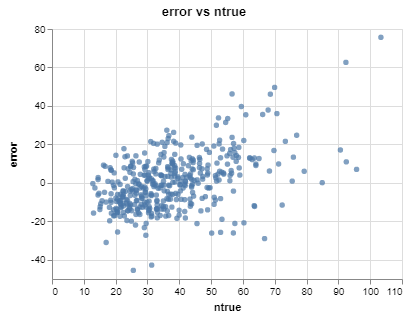

In [11]:
chart = alt.Chart(csv_test).mark_circle().encode(
    x='ntrue',
    y='error'
).properties(
    title='error vs ntrue',
    width=350,
    height=250
)

chart

It looks like: the more vehicles there are, the higher the predicted error is.

In [12]:
x = csv_test['ntrue']
y = csv_test['error']

x = sm.add_constant(x)
error_ntrue_model = sm.OLS(y,x).fit()

error_ntrue_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     130.6
Date:                Wed, 21 Nov 2018   Prob (F-statistic):           1.66e-26
Time:                        21:53:50   Log-Likelihood:                -1659.7
No. Observations:                 421   AIC:                             3323.
Df Residuals:                     419   BIC:                             3332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.7180      1.620    -10.319      0.000     -19.903     -13.533
ntrue          0.4562      0.040     11.426      0.000       0.378       0.535
==============================================================================
Omnibus:                       10.324   Durbin-Watson:                   0.670
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               18.795
Skew:                           0.022   Prob(JB):                     8.29e-05
Kurtosis:                       4.034   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the p-value and chart, there seems to be some direct(positive coeficient) lineal relationship between ground_true values and prediction error.

### Density vs error:

In order to analyze the association between "traffic density" and "prediction error", we will use the following function:

**"avg__euc_distance"**: This function returns the average euclidean distance between each object and the rest.<br>

We will use this function to measure the **degree of concentration** of annotated vehicles.


In [13]:
def avg_euc_distance(coord_list):
    
    '''
    This function returns the average euclidean distance between each object and the rest.
    In this project, an object is an annotated vehicle.
    
    @param: coord_list: List of coordinates of the objects
    
    '''
    
    list_len = len(coord_list) #amount of coordinates
    
    distances = np.zeros((list_len,list_len)) #To store distances between coordinates 
    
    #Iterate over a list of coordinates, calculating the euclidean distance between 
    #every pair of coordinates (objects) of the list
    for i,x in enumerate(coord_list):
        for j,y in enumerate(coord_list):
            distances[i,j] = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))
         
    #Calculate the average distance   
    return np.sum(distances)/(list_len**2-list_len)   

The input for this function will be files with the coordinates of annotated vehicles, included in TRANCOS data_set.<br>
They have the same name as the images but their extension is "txt" instead "jpg".

We will apply this function to every input, in order to obtain the traffic density value for each image ("AvgDistance"),<br>
Save these data in a data_frame and, <br>
Merge it with the data_frame we have been using so far (csv_test).


In [14]:
df_list = []

for img_path in img_paths:
 
    x=[]
    y=[]
    
    with open(img_path.replace('.jpg','.txt'),'r') as f:
        reader = csv.reader(f,delimiter='\t')
        for row in reader:
            x.append(int(row[0]))
            y.append(int(row[1]))
        
    dots_gt = list(zip(x,y))
    dots_avg_dist = avg_euc_distance(dots_gt)
        
    img_number = str(img_path[-12:-4])
        
    row = [img_number, dots_avg_dist]
   
    df_list.append(row)

df_distances =  pd.DataFrame(df_list, columns=['img', 'AvgDistance']) 
df_distances.head()

,img,AvgDistance
0,3-000001,105.804735
1,3-000002,122.158061
2,3-000003,116.716648
3,3-000004,111.812647
4,3-000005,100.382195


In [15]:
test_df = pd.merge(csv_test, df_distances)
test_df.head()

,img,ndots,ntrue,npred,error,abs_err,re_error,AvgDistance
0,3-000421,35.0,33.091682,51.260645,-18.168963,18.168963,-0.549049,168.379286
1,3-000420,45.0,43.518074,41.013837,2.504237,2.504237,0.057545,161.699975
2,3-000419,38.0,35.039540,34.221519,0.818021,0.818021,0.023346,161.145823
3,3-000418,33.0,31.251856,37.867658,-6.615802,6.615802,-0.211693,147.118154
4,3-000417,41.0,38.688330,38.268263,0.420067,0.420067,0.010858,141.423906


Let´s take a look at the behaviour of **AvgDistance vs prediction error** in a chart:

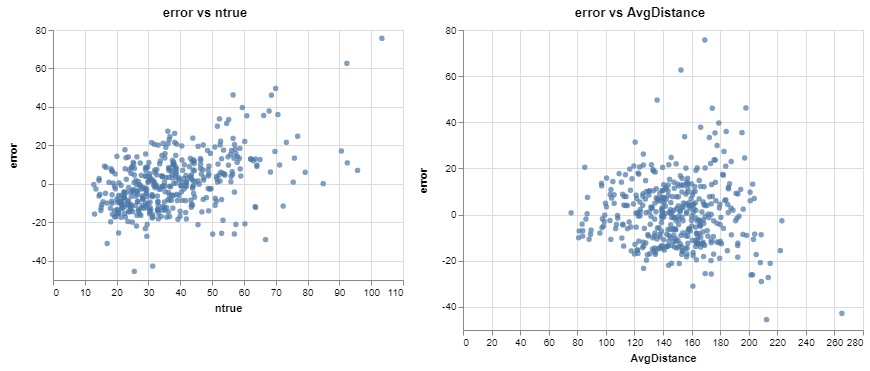

In [16]:
chart_dist = alt.Chart(test_df).mark_circle().encode(
    x='AvgDistance',
    y='error'
).properties(
    title='error vs AvgDistance',
    width=400,
    height=300
) 

chart | chart_dist

Based on the chart, it seems that the relationship with the absolute error is much stronger than with error.
Let´s see the lineal regresion:

In [17]:
x = test_df['AvgDistance']
y = test_df['abs_err']

x = sm.add_constant(x)
density_ntrue_model = sm.OLS(y,x).fit()

density_ntrue_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                abs_err   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     24.11
Date:                Wed, 21 Nov 2018   Prob (F-statistic):           1.31e-06
Time:                        21:53:55   Log-Likelihood:                -1521.4
No. Observations:                 421   AIC:                             3047.
Df Residuals:                     419   BIC:                             3055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4229      2.348     -0.180      0.857      -5.039       4.193
AvgDistance     0.0758      0.015      4.910      0.000       0.045       0.106
==============================================================================
Omnibus:                      222.375   Durbin-Watson:                   1.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1767.936
Skew:                           2.134   Prob(JB):                         0.00
Kurtosis:                      12.087   Cond. No.                         814.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the p-value, there is some lineal relationship between the "average distance between vehicles" (AvgDistance) and the prediction error, but much weaker than the previous variable (see p-value and R-squared). 

In [18]:
print("min: %i, mean: %i" % (min(test_df['AvgDistance']), np.median(test_df['AvgDistance'])))

min: 75, mean: 149


(array([ 13.,  32.,  63., 113., 112.,  55.,  25.,   7.,   0.,   1.]),
 array([ 75.69375036,  94.64492797, 113.59610558, 132.54728319,
        151.4984608 , 170.44963842, 189.40081603, 208.35199364,
        227.30317125, 246.25434886, 265.20552647]),
 <a list of 10 Patch objects>)

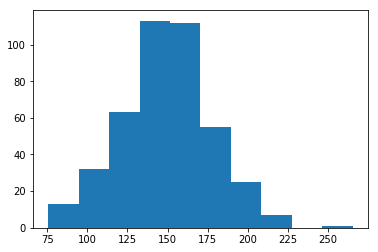

In [19]:
plt.hist( test_df['AvgDistance'])

The prediction error seems to show specially high positive and negative values after an average distance of 160, so we will keep this metric as a measure of vehicles dispersion.

The values of average distances may be affected by several factors such as: the dispersion between different focuses of concentration, the geometry of the concentration (line vs a circle), ...<br>
For this reason, we will use a complementary metric for density analysis.

As one of the major issues caused by concentration is overlapping, we will use an additional metric to measure this effect.
For each image, we are going to calculate the number of vehicles whose distance to their closest one is lower than a threshold.

We will use the following function for this purpose:

In [20]:
def overlapping_func(coord_list, threshold):

    '''
    This function returns the number of positions whose distance to their closest one is lower than a threshold.
    
    @param: coord_list: List of coordinates of the objects
    @param: threshold: maximum distance from one position to another, required for positions to be counted. 
    
    Note: In this porject, position = vehicle
    
    '''
    list_len = len(coord_list) #number of coordinates
    
    distances = np.zeros((list_len,list_len))  #To store distances between two coordinates
    
    #Iterates over a list of coordinates, calculating the euclidean distance between 
    #every pair of coordinates (positions) of the list
    for i,x in enumerate(coord_list):
        for j,y in enumerate(coord_list):
            distances[i,j] = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))
            
    
    min_distances = [] #List of distances below the threshold
    
    #Iterates over positions (rows) to collect the distance of each position to its closest one.
    #Then, it selects only those distances lower than the threshold
    for ind,dist in enumerate(distances):
        n_clean = list(dist) #List of distances of a given object to the rest
        del n_clean[ind] #Clearing the distance of an object to itself, which is "0"
        min_dist = min(n_clean) #Distance of a given object to its closest one
        if min_dist<threshold:
            min_distances.append(min_dist)
        
    #Number of distances below the threshold    
    return len(min_distances)  

Now, we will set the threshold (after trying several values, 15 is the one that provides the best R^2 for lineal regresions between prediction error and overlapping).<br>
Then, we will use the function above to measure overlapping as traffic concentration based on the number of vehicles that are close enough to another one.

In [21]:
df_list = []
threshold = 15

for img_path in img_paths:
 
    x=[]
    y=[]
    
    with open(img_path.replace('.jpg','.txt'),'r') as f:
        reader = csv.reader(f,delimiter='\t')
        for row in reader:
            x.append(int(row[0]))
            y.append(int(row[1]))
        
    dots_gt = list(zip(x,y))
    
    dots_below_th = overlapping_func(dots_gt,threshold)
        
    img_number = str(img_path[-12:-4])
        
    row = [img_number, dots_below_th]
   
    df_list.append(row)

df_dots_below_th =  pd.DataFrame(df_list, columns=['img', 'overlapping']) 



Let´s add this metric to our main dataframe

In [22]:
test_df = pd.merge(test_df, df_dots_below_th)
test_df.head()

,img,ndots,ntrue,npred,error,abs_err,re_error,AvgDistance,overlapping
0,3-000421,35.0,33.091682,51.260645,-18.168963,18.168963,-0.549049,168.379286,13
1,3-000420,45.0,43.518074,41.013837,2.504237,2.504237,0.057545,161.699975,10
2,3-000419,38.0,35.039540,34.221519,0.818021,0.818021,0.023346,161.145823,12
3,3-000418,33.0,31.251856,37.867658,-6.615802,6.615802,-0.211693,147.118154,4
4,3-000417,41.0,38.688330,38.268263,0.420067,0.420067,0.010858,141.423906,17


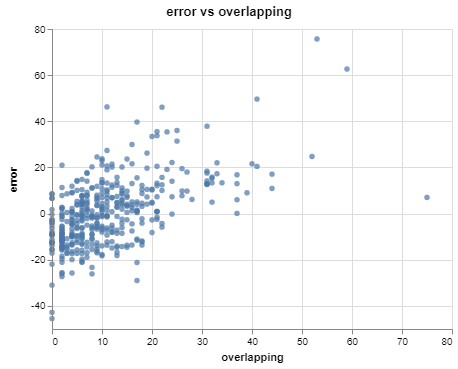

In [23]:
chart_overlap = alt.Chart(test_df).mark_circle().encode(
    x='overlapping',
    y='error'
).properties(
    title='error vs overlapping',
    width=400,
    height=300
)
chart_overlap

The chart seems to show that the more overlapping the more predicition error

In [24]:
x = test_df['overlapping']
y = test_df['error']

x = sm.add_constant(x)
theshold_ntrue_model = sm.OLS(y,x).fit()

theshold_ntrue_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     192.6
Date:                Wed, 21 Nov 2018   Prob (F-statistic):           2.68e-36
Time:                        21:54:01   Log-Likelihood:                -1637.2
No. Observations:                 421   AIC:                             3278.
Df Residuals:                     419   BIC:                             3286.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.5269      0.866     -9.842      0.000     -10.230      -6.824
overlapping     0.7970      0.057     13.878      0.000       0.684       0.910
==============================================================================
Omnibus:                       18.788   Durbin-Watson:                   0.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.628
Skew:                           0.300   Prob(JB):                     1.36e-07
Kurtosis:                       4.201   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This metric has the highest values of p-value and R-squared.

Let´s see how this metric behaves grouped by bins.

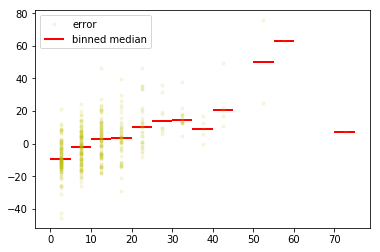

In [25]:
x_abs = test_df['overlapping']
y_abs = test_df['error']

bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(x_abs, y_abs, statistic='median', bins=15, range=None)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2, label='binned median')
plt.plot((binnumber - 0.5) * bin_width, y_abs, 'y.', alpha=0.1)
plt.legend(fontsize=10)
plt.show()

Although this chart shows certain direct relationship between vehicles overlapping and prediction error, it also makes clear 
the unbalanced number of samples for each level of overlapping (bin). <br>

This is a consequence of the composition of TRANCOS dataset.<br>
As it was already mentioned in "ii_TRANCOS_db" notebook of this project, related to '2) Data_set: Selection and validation' section, the amount of images provided by this dataset with "overlapping" lower than 20 vehicles is much higher than those with "overlapping" over 20 vehicles. <br>

This TRANCOS' limitation makes very weak any conclusion based on data from images with "overlapping" over 20 vehicles.

Another pattern detected is related to the distribution of the sign of errors, which has a predominance of negative ones for low values of ground_truth or "overlapping" turnning into positive as they (ground_truth or overlapping) increase.

**To address a deeper analysis of errors, I have extended the information related to images by the addition of the traffic camera number which will be used to identify the images taken from each camera.**

*(Note: This additional information is not included in TRANCOS dataset. It was manually obtained from images for this project.)*

This information can be found on 'image_cam-csv' included in this project:

In [26]:
image_cam = pd.read_csv('./image_cam.csv')
image_cam.head()

,img,cam
0,3-000001,cam206
1,3-000002,cam206
2,3-000003,cam206
3,3-000004,cam206
4,3-000005,cam206


In [27]:
# we will add traffic camera numbers to our main dataframe:

test_df = pd.merge(test_df, image_cam)
test_df.head()

,img,ndots,ntrue,npred,error,abs_err,re_error,AvgDistance,overlapping,cam
0,3-000421,35.0,33.091682,51.260645,-18.168963,18.168963,-0.549049,168.379286,13,cam510
1,3-000420,45.0,43.518074,41.013837,2.504237,2.504237,0.057545,161.699975,10,cam510
2,3-000419,38.0,35.039540,34.221519,0.818021,0.818021,0.023346,161.145823,12,cam510
3,3-000418,33.0,31.251856,37.867658,-6.615802,6.615802,-0.211693,147.118154,4,cam510
4,3-000417,41.0,38.688330,38.268263,0.420067,0.420067,0.010858,141.423906,17,cam510


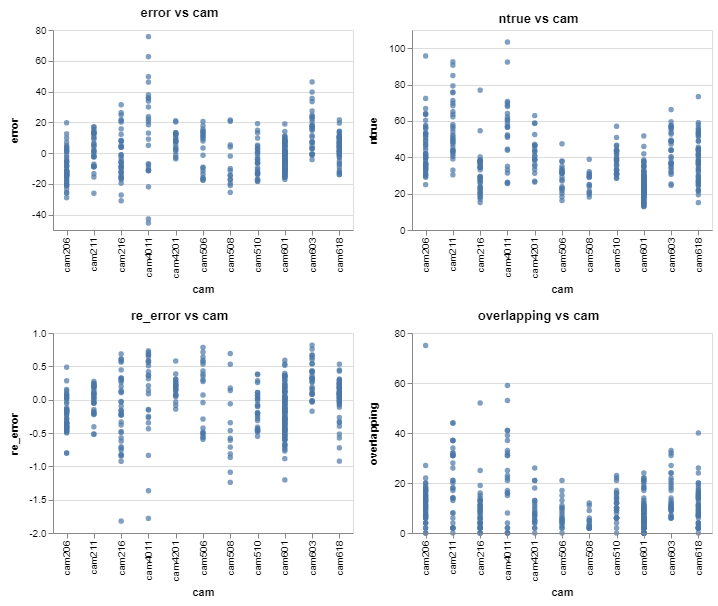

In [28]:

chart_cam_err = alt.Chart(test_df).mark_circle().encode(
    x='cam',
    y='error'
).properties(
    title='error vs cam',
    width=300,
    height=200
)

chart_cam_true = alt.Chart(test_df).mark_circle().encode(
    x='cam',
    y='ntrue'
).properties(
    title='ntrue vs cam',
    width=300,
    height=200
)

chart_cam_re = alt.Chart(test_df).mark_circle().encode(
    x='cam',
    y='re_error'
).properties(
    title='re_error vs cam',
    width=300,
    height=200
)

chart_cam_ovlap = alt.Chart(test_df).mark_circle().encode(
    x='cam',
    y='overlapping'
).properties(
    title='overlapping vs cam',
    width=300,
    height=200
)

(chart_cam_err | chart_cam_true) &  (chart_cam_re | chart_cam_ovlap)

Above, we can see that there are a wide variety of cameras.
We can observe that: 

- Cameras with low values of overlapping (i.e.: cam508) have a high amount of negative errors and cameras with higher percentage of overlapping have much more positive errors (i.e.: cam603).<br>
These results support the idea of certain relationship between vehicles overlapping and prediction error.<br>


- There are two cameras with high number of vehicles (ntrue) and high overlapping but their number of errors don´t behave the same way.<br>
Cam4011 has much higher error values than cam211.<br>
These results may be suggesting that "ntrue" and "overlapping" don´t have a strong association with errors by themselves.


The following graph is really usefull to check images by camera and to select samples:

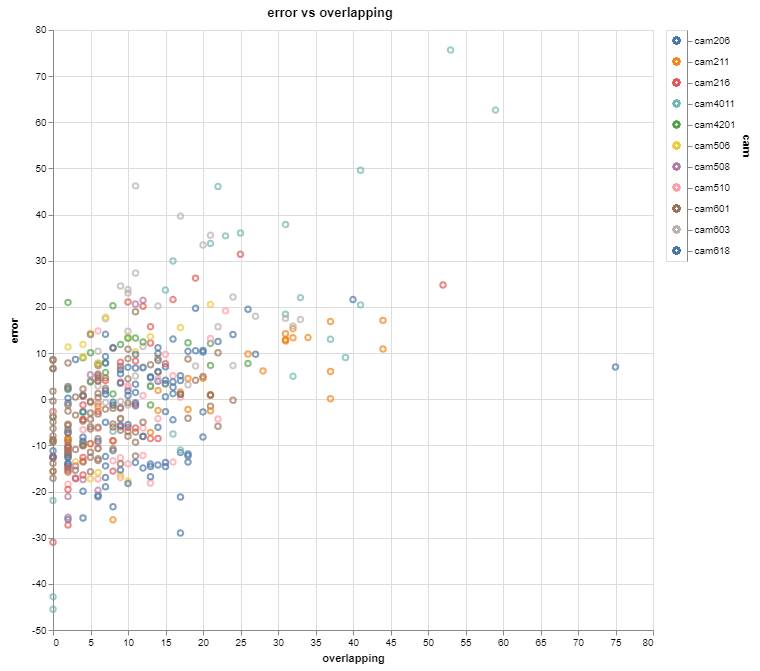

In [29]:
selection = alt.selection_multi(fields=['cam'])
color = alt.condition(selection,
                      alt.Color('cam:N', legend=None),
                      alt.value('lightgray'))

scatter = alt.Chart(test_df).mark_point().encode(
    x='overlapping:Q',
    y='error:Q',
    color=color,
    tooltip='img:N'
).properties(
    title='error vs overlapping',
    width=600,
    height=600
)

legend = alt.Chart(test_df).mark_point().encode(
    y=alt.Y('cam:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

scatter | legend

### Brightness vs error:

Image features can have a relevant impact on the capability of a model to learn patterns.<br>
We are going to test one of the most relevant, brightness, and its effect on prediction error.

First, we will calculate a metric that allows us to measure brightness. <br>
The selected **metric** is the **pixels mean** of images. <br>
Its interpretation is: **the higher the mean the brighter the image** 

In [30]:
bright_df = pd.DataFrame(columns=['img','bright'])

for i,img in enumerate(img_paths):
    mask_im_path = img.replace('.jpg','mask.mat')
    mask = sio.loadmat(mask_im_path, chars_as_strings=1, matlab_compatible=1)
    mask = mask.get('BW')
    
    im = skimage.img_as_float(skimage.io.imread(img)).astype(np.float32)
    im = im[mask]
    im_mean = im.mean()
    img = str(img[-12:-4])   
    bright_df.loc[i] = [img, im_mean] 

In [31]:
test_df = pd.merge(test_df, bright_df)
test_df.head()

,img,ndots,ntrue,npred,error,abs_err,re_error,AvgDistance,overlapping,cam,bright
0,3-000421,35.0,33.091682,51.260645,-18.168963,18.168963,-0.549049,168.379286,13,cam510,0.618236
1,3-000420,45.0,43.518074,41.013837,2.504237,2.504237,0.057545,161.699975,10,cam510,0.544191
2,3-000419,38.0,35.039540,34.221519,0.818021,0.818021,0.023346,161.145823,12,cam510,0.546671
3,3-000418,33.0,31.251856,37.867658,-6.615802,6.615802,-0.211693,147.118154,4,cam510,0.540751
4,3-000417,41.0,38.688330,38.268263,0.420067,0.420067,0.010858,141.423906,17,cam510,0.531313


Taking a look at some cameras, we can distinguish an association of brightness with prediction error that advises us to keep this variable.<br>
For example, if we collect all the images, on a given day, from one of the cameras with higher predicition error, the graph we get is as follows:

In [32]:
img_4011cam =['3-000404', '3-000405','3-000406', '3-000407', '3-000408', '3-000409', '3-000410', '3-000411', '3-000412', 
              '3-000413'] 

cam4011_df = test_df[test_df['img'].isin(img_4011cam)]

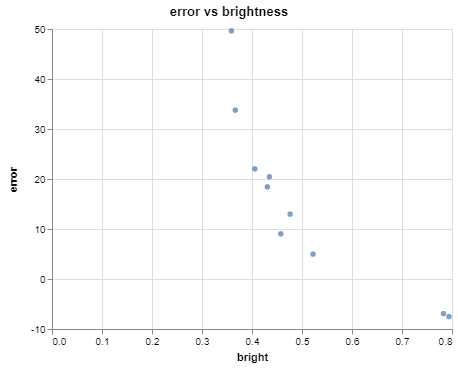

In [33]:
chart_4011 = alt.Chart(cam4011_df).mark_circle().encode(
    x='bright',
    y='error'
).properties(
    title='error vs brightness',
    width=400,
    height=300
)

chart_4011

**SUMMARY:**

Up to know, what we have learned about our model´s prediction errors is as follows:

**Ground_truth(ntrue)** and **"overlapping"** vs error: <br>
Both, overlapping and ground_truth, have certain direct relationship with prediction error but not strong enough by themselves.<br>
Distribution of the sign of errors: Predominance of negative ones for low values of ground_truth or "overlapping" turnning into positive as they increase.

**Dispersion ('AvgDistance' variable)** vs error:<br>
High positive and negative error values for high levels of dispersion (from average distance of 160 on).

**Brightness vs error**:<br>
We will use this variable as an example of the impact of features of an image proper.


### Clustering of High Prediction Error :

Now, we are going to look for profiles of high prediction error based on the four variables that we have analysed above: <br> 
Number of vehicles (ntrue), overlapping, brightness (bright) and dispersion (AvgDistance)

For this purpose, we will apply cluster analysis using **k-means** clustering.

First, let´s assign prediction error levels by setting a threshold that will be used to classify prediction errors as "High" or "Low" level.

(array([  2.,   9., 102., 137., 120.,  36.,   9.,   4.,   1.,   1.]),
 array([-45.51122324, -33.39290301, -21.27458278,  -9.15626254,
          2.96205769,  15.08037792,  27.19869816,  39.31701839,
         51.43533862,  63.55365885,  75.67197909]),
 <a list of 10 Patch objects>)

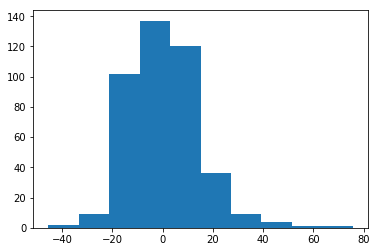

In [34]:
#Having a look at the histogram below, we can see that a threshold of 10 will provide us 
#with a sample of "High" prediciton errors big enough to extract useful information from.

plt.hist( test_df['error'])

In [35]:
# Let´s create a categorical variable for prediction error level:

test_df['error_th10'] = test_df.apply(lambda row: "High" if row['abs_err']>10 else "Low", axis=1 )

In [36]:
test_df.head()

,img,ndots,ntrue,npred,error,abs_err,re_error,AvgDistance,overlapping,cam,bright,error_th10
0,3-000421,35.0,33.091682,51.260645,-18.168963,18.168963,-0.549049,168.379286,13,cam510,0.618236,High
1,3-000420,45.0,43.518074,41.013837,2.504237,2.504237,0.057545,161.699975,10,cam510,0.544191,Low
2,3-000419,38.0,35.039540,34.221519,0.818021,0.818021,0.023346,161.145823,12,cam510,0.546671,Low
3,3-000418,33.0,31.251856,37.867658,-6.615802,6.615802,-0.211693,147.118154,4,cam510,0.540751,Low
4,3-000417,41.0,38.688330,38.268263,0.420067,0.420067,0.010858,141.423906,17,cam510,0.531313,Low


In [37]:
test_df.describe()

,ndots,ntrue,npred,error,abs_err,re_error,AvgDistance,overlapping,bright
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,39.574822,37.596576,37.161420,0.435157,10.905642,-0.058032,149.387943,11.244656,0.495636
std,16.040640,15.276107,14.996339,14.299217,9.243441,0.402279,28.433233,10.068078,0.111637
min,13.000000,12.829671,4.872220,-45.511223,0.083155,-1.821257,75.693750,0.000000,0.210617
25%,28.000000,26.337576,27.976634,-9.653314,4.453817,-0.344734,131.919614,4.000000,0.415203
50%,37.000000,35.039540,36.004903,-0.491358,9.193141,-0.017850,149.614940,9.000000,0.494680
75%,49.000000,45.943848,45.386143,8.589064,14.271030,0.208882,166.437050,15.000000,0.560267
max,107.000000,103.375890,95.807532,75.671979,75.671979,0.816891,265.205526,75.000000,0.793945


Now, we will save this data_frame to a "csv" file that we will use to **apply k-means using "R"**.

(Note: If you prefer to use Python, you can use KMeans from sklearn.cluster.) 

In [38]:
# Creating file with our main data_frame to be used by R:
test_df.to_csv('R/test_r')

The "k-means" clustering can be found in ["R" folder](https://github.com/jorgealcubilla/TFM_DataScience/tree/master/R) of this project.<br>

The features used in K-means clustering are the variables analysed up to now, which are:
- Ground_truth ('ntrue')
- Overlapping
- Dispersion ('AvgDistance')
- Brightness ('bright')

In order to detect images with "high predicition error", we have selected the clusters that more clearly represent it.<br>
Each cluster contains a **different combination of feature levels (see below)**, making them representative of specific profiles for high levels of predicition error.

The clustering obtained by our k-means application with R (see file ['k_means_clustering.R' ](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/R/k_means_clustering.R)saved in 'R' folder of this project) are as follows:

**Cluster# 14:**
Highest positive errors. It combines high values for all the variables <br>
(brightness which is specially high, groundtruth, overlapping and dispersion) <br>

**Cluster# 6:**
Highest negative errors<br>
High brightness and specially high dispersion  <br>
Moderate ground_truth, low overlapping <br>
 
**Cluster# 9:** 
Negative errors<br>
High brightness, low dispersion<br>
Moderate ground_truth, low overlapping<br>

**Cluster# 15:** 
Positive errors<br>
Moderate brightness and dispersion<br>
High ground_truth and overlapping<br>

**Cluster# 1:** 
Positive errors, from moderate to extremely high<br>
High brightness and dispersion<br>
Highest ground_truth and overlapping<br>


*See samples of these clusters included in ["clusters_sample"](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/clusters_sample/clusters_sample.ipynb) notebook in folder "clusters_sample" of this project*

Now, let´s add the clusters allocation to our main data_frame

In [39]:
clustersR =  pd.read_csv('R/clustersR.csv')
clustersR.head()

,Unnamed: 0,img,Clusters
0,1,3-000421,9
1,2,3-000420,7
2,3,3-000419,7
3,4,3-000418,3
4,5,3-000417,5


In [40]:
test_df = pd.merge(test_df, clustersR[['img','Clusters']])
test_df.head()

,img,ndots,ntrue,npred,error,abs_err,re_error,AvgDistance,overlapping,cam,bright,error_th10,Clusters
0,3-000421,35.0,33.091682,51.260645,-18.168963,18.168963,-0.549049,168.379286,13,cam510,0.618236,High,9
1,3-000420,45.0,43.518074,41.013837,2.504237,2.504237,0.057545,161.699975,10,cam510,0.544191,Low,7
2,3-000419,38.0,35.039540,34.221519,0.818021,0.818021,0.023346,161.145823,12,cam510,0.546671,Low,7
3,3-000418,33.0,31.251856,37.867658,-6.615802,6.615802,-0.211693,147.118154,4,cam510,0.540751,Low,3
4,3-000417,41.0,38.688330,38.268263,0.420067,0.420067,0.010858,141.423906,17,cam510,0.531313,Low,5


Then, we are going to translate clusters into levels of prediction error ("High" and "Low") based on the the clusters# that we have already categorized as "High"

In [41]:
test_df['error_class'] = test_df.apply(lambda row: "High" if (row['Clusters']==1) or (row['Clusters']==6) or
                                       (row['Clusters']==9) or (row['Clusters']==14) or (row['Clusters']==15) 
                                       else "Low", axis=1 )

We use this information to build its related confusion matrix:

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_df['error_th10'], test_df['error_class'], labels=["High", "Low"])

# Estimation vs Ground_truth

array([[ 71, 125],
       [  9, 216]], dtype=int64)

Our clustering provides:
High precision (71/80 = 89%) due to our selection of highly representative profiles.
A decent Recall (71/125 = 36%) for our first approach to model improvement. 

Thus, we have identified the profile for the 36% of images with high level of prediction error (>10 errors) with an 89% of precision.

Some additional analysis of the true_positives sample:

In [43]:
pred_tp = test_df[(test_df['error_class']=='High')&(test_df['error_th10']=='High')]
errorByCam = pred_tp.groupby('cam').agg({'error': 'sum', 'img': 'count'})
errorByCam

,error,img
cam,,
cam206,-367.298693,20
cam211,113.177941,11
cam216,56.153716,2
cam4011,416.251656,16
cam510,-90.074884,8
cam601,-12.281751,1
cam603,261.365974,10
cam618,55.109817,3


In [44]:
# The MAE of this sample is:
int(np.sum(abs(errorByCam['error']))/len(pred_tp))

19

Thus, we could reduce the total MAE of the selected model if we lower the MAE of this sample. 

## Conclusions:

There are several factors affecting the effectiveness of our trained model.

The factors we have analyzed in this notebook are: 
- Ground_truth ('ntrue')
- Overlapping
- Dispersion ('AvgDistance')
- Brightness ('bright')

These factors have certain association with predicition error by themselves but the effect of their combination is much clearer and stronger.

We used k-means clustering to look for combinations of these factor causing high prediction errors on our model.<br>
These combinations are described by 5 clusters (see above), and what we can deduct from them is as follows:

- From clusters# 1,14&15: Estimations exceed ground_truth (negative error) when there is a combination of high level of brightness and low overlapping. This gap increases if there is high dispersion too.

- From clusters#  6&9: Estimations are below ground_truth (positive error) when there is a combination of high values of ground_truth and overlapping.<br>
The addition of high brightness to this combination seems to increase this gap.

The main goal of this notebook is to find the way to improve the outcomes of the selected model. <br>
Based on our results, an additional training could provide us with a more accurate (less prediction errors) model and increase its generalization capability.

As we could see when we analized TRANCOS dataset in ['ii_TRANCOS_db'](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/ii_TRANCOS_db.ipynb) notebook of this project, the amount of images with high ground_truth (>50) and/or high overlapping (>20) in its training and validation datasets are very low.<br>
Since clusters# 15, 14 and 1 are made up of these kinds of images, we don´t know whether the kinds of errors represented by these clusters are a consequence of insufficient training or due to limitations of the model itself. 

In fact, we have seen images with high values of ground_truth and overlapping but low error (i.e.: image# 285), so the model could have room for improvement via training. 

Therefore, the proposal for model improvement is to carry out additional traning using images that fit the features of clusters described above and summarized in this section.


### TODO:

Next steps: 

- Use decision-tree methods to improve our classification of error profiles and work on additional variables such as contrast (we have used variance without success).
- Train the model with a more balanced dataset